# Project Setup

In [208]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
import seaborn as sns
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

We'll also import Plotly and enable the offline mode.

In [363]:
import ccxt
poloniex = ccxt.poloniex()
poloniex.id
json_dict=poloniex.load_markets()
#get all currencies available
curr_list=[]
for curr_pair in json_dict:
    first,second=curr_pair.split('/')
    if second=='BTC':
        if first!='Bitmark':
            curr_list.append(first)
print (curr_list)

['BCN', 'BELA', 'BLK', 'BTCD', 'BTS', 'BURST', 'CLAM', 'DASH', 'DGB', 'DOGE', 'EMC2', 'FLDC', 'FLO', 'GAME', 'GRC', 'HUC', 'LTC', 'MAID', 'OMNI', 'NAV', 'NEOS', 'NMC', 'NXT', 'PINK', 'POT', 'PPC', 'RIC', 'XLM', 'SYS', 'VIA', 'XVC', 'VRC', 'VTC', 'XBC', 'XCP', 'XEM', 'XMR', 'XPM', 'XRP', 'ETH', 'SC', 'BCY', 'EXP', 'FCT', 'RADS', 'AMP', 'DCR', 'LSK', 'LBC', 'STEEM', 'SBD', 'ETC', 'REP', 'ARDR', 'ZEC', 'STRAT', 'NXC', 'PASC', 'GNT', 'GNO', 'BCH', 'ZRX', 'CVC', 'OMG', 'GAS', 'STORJ']


# Retrieve Bitcoin Pricing Data
Now that everything is set up, we're ready to start retrieving data for analysis.  First, we need to get Bitcoin pricing data using [Quandl's free Bitcoin API](https://blog.quandl.com/api-for-bitcoin-data).

## Define Quandl Helper Function
To assist with this data retrieval we'll define a function to download and cache datasets from Quandl.

In [365]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

We're using `pickle` to serialize and save the downloaded data as a file, which will prevent our script from re-downloading the same data each time we run the script.  The function will return the data as a [Pandas]('http://pandas.pydata.org/') dataframe.  If you're not familiar with dataframes, you can think of them as super-powered Python spreadsheets.

## Pull Kraken Exchange Pricing Data
Let's first pull the historical Bitcoin exchange rate for the [Kraken](https://www.kraken.com/) Bitcoin exchange.

In [366]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [367]:
btc_usd_price_kraken.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


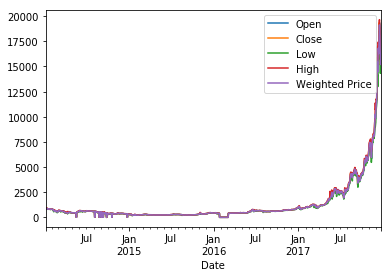

In [368]:
# Chart the BTC pricing data
%matplotlib inline
btc_usd_price_kraken[['Open','Close','Low','High','Weighted Price']].plot()

In [369]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [370]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [371]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [372]:
btc_usd_datasets.tail()

,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2017-12-18,18634.418590,18779.790859,18640.346919,18683.675327
2017-12-19,17986.053806,18046.801749,17934.823780,18093.126238
2017-12-20,16724.840365,16627.512506,16644.736331,16515.544624
2017-12-21,16033.611116,16072.079918,15940.292149,15707.989038
2017-12-22,15671.434483,NaN,NaN,15205.831352


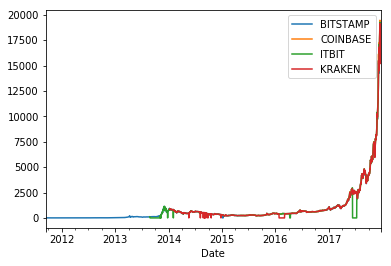

In [373]:
btc_usd_datasets.plot()


In [374]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

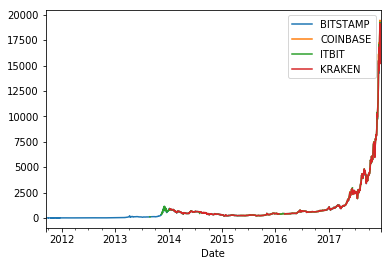

In [375]:
btc_usd_datasets.plot()

In [376]:
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

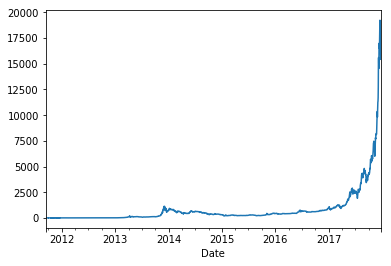

In [377]:
# Plot the average BTC price
btc_usd_datasets['avg_btc_price_usd'].plot()


In [378]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    #     try:        
    #         f = open(cache_path, 'rb')
    #         df = pickle.load(f)   
    #         print('Loaded {} from cache'.format(json_url))
    #     except (OSError, IOError) as e:
    print('Downloading {}'.format(json_url))
    df = pd.read_json(json_url)
    df.to_pickle(cache_path)
    print('Cached response at {}'.format(json_url, cache_path))
    return df

In [379]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2017-11-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
period = 7200 # pull daily data (86,400 seconds per day)

    
def get_crypto_data(poloniex_pair,period):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [382]:
altcoins = ['BTC','ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM','ZEC','NEOS','OMG','NAV','STEEM','VTC','NXT','LSK','DGB','SC']
altcoins=curr_list+['BTC']

altcoin_data = {}
for altcoin in altcoins:
    if altcoin =='BTC':
        coinpair='USDT_BTC'
    else:
        coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair,period)
    altcoin_data[altcoin] = crypto_price_df

Cached response at https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BCN&start=1509490800.0&end=1514382422.285829&period=7200
Cached response at https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BELA&start=1509490800.0&end=1514382422.285829&period=7200
Cached response at https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BLK&start=1509490800.0&end=1514382422.285829&period=7200
Cached response at https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BTCD&start=1509490800.0&end=1514382422.285829&period=7200
Cached response at https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BTS&start=1509490800.0&end=1514382422.285829&period=7200
Cached response at https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BURST&start=1509490800.0&end=1514382422.285829&period=7200
Cached response at https://poloniex.com/public?command=returnChartData&currencyPair=BTC_CLAM&start=1509490800.0&end=1514382422

ValueError: If using all scalar values, you must pass an index

In [ ]:
altcoin_data['ETH'].tail()

In [ ]:
# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoin_data.keys():
    if altcoin is not 'BTC':
        altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * altcoin_data['BTC']['weightedAverage']
    elif altcoin is 'BTC':
        altcoin_data['BTC']['price_usd']=altcoin_data['BTC']['weightedAverage']

In [ ]:
#altcoin_data
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

In [ ]:
# Add BTC price to the dataframe
#combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

In [ ]:
combined_df_2017=combined_df.loc[start_date:end_date]

In [325]:
# Chart all of the altocoin prices
log_df=np.log(combined_df_2017).diff()

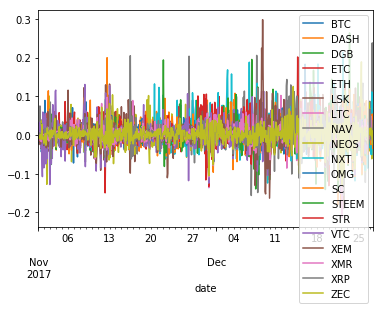

In [326]:
log_df.plot()

BTC       1.299143
DASH      3.676563
DGB       3.989630
ETC       2.345392
ETH       1.470749
LSK       3.804094
LTC       4.236037
NAV       1.917390
NEOS      1.530813
NXT      18.051875
OMG       1.287716
SC        5.035251
STEEM     2.542117
STR       7.644181
VTC       0.632325
XEM       3.979377
XMR       3.448225
XRP       4.718952
ZEC       1.553432
Name: 2017-12-22 00:00:00, dtype: float64

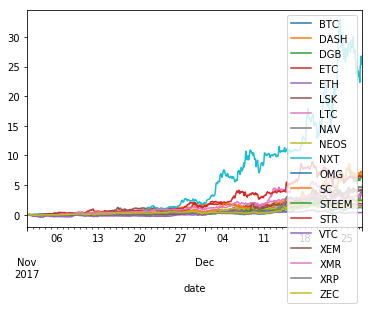

In [327]:
( (np.exp(log_df.cumsum()) - 1)).plot()
( (np.exp(log_df.cumsum()) - 1)).loc[datetime.strptime('2017-12-22', '%Y-%m-%d')]


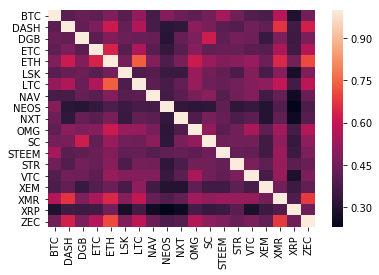

In [383]:
combined_df_2017 = combined_df[combined_df.index.year == 2017]
sns.heatmap(combined_df_2017.pct_change().corr(method='pearson'))

In [331]:
combined_df.resample('D').pct_change().add(1).prod().pow(1./(len(combined_df_2017.columns) - 1)).sub(1)


/home/pauli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.resample() is now a deferred operation
You called pct_change(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  """Entry point for launching an IPython kernel.


BTC      0.051015
DASH     0.084944
DGB      0.118258
ETC      0.060817
ETH      0.052889
LSK      0.096872
LTC      0.094625
NAV      0.081292
NEOS     0.070001
NXT      0.197932
OMG      0.048688
SC       0.123809
STEEM    0.072678
STR      0.120756
VTC      0.019696
XEM      0.097779
XMR      0.086544
XRP      0.102367
ZEC      0.050098
dtype: float64

# Your Turn

This explanation is, however, largely speculative.  **Maybe you can do better**.  With the foundation we've made here, there are hundreds of different paths to take to continue searching for stories within the data.  

Here are some ideas:

- Add data from more cryptocurrencies to the analysis.
- Adjust the time frame and granularity of the correlation analysis, for a more fine or coarse grained view of the trends. 
- Search for trends in trading volume and/or blockchain mining data sets.  The buy/sell volume ratios are likely more relevant than the raw price data if you want to predict future price fluctuations.
- Add pricing data on stocks, commodities, and fiat currencies to determine which of them correlate with cryptocurrencies (but please remember the old adage that "Correlation does not imply causation").
- Quantify the amount of "buzz" surrounding specific cryptocurrencies using Event Registry, GDLELT, and Google Trends. 
- Train a predictive machine learning model on the data to predict tomorrow's prices.  If you're more ambitious, you could even try doing this with a recurrent neural network (RNN).
- Use your analysis to create an automated "Trading Bot" on a trading site such as Poloniex or Coinbase, using their respective trading APIs.  Be careful: a poorly optimized trading bot is an easy way to lose your money quickly.
- **Share your findings!**  The best part of Bitcoin, and of cryptocurrencies in general, is that their decentralized nature makes them more free and democratic than virtually any other market.  Open source your analysis, participate in the community, maybe write a blog post about it.

Hopefully, now you have the skills to do your own analysis and to think critically about any speculative cryptocurrency articles you might read in the near future, especially those written without any data to back up the provided predictions.

Thanks for reading, and feel free to comment below with any ideas, suggestions, or criticisms regarding this tutorial.  I've got second (and potentially third) part in the works, which will likely be following through on some of same the ideas listed above, so stay tuned for more in the coming weeks.

[^1]: http://fortune.com/2017/07/26/bitcoin-cryptocurrency-hedge-fund-sequoia-andreessen-horowitz-metastable/
[^2]: https://www.forbes.com/sites/laurashin/2017/07/12/crypto-boom-15-new-hedge-funds-want-in-on-84000-returns/#7946ab0d416a

In [333]:
# coding=utf-8


# hitbtc = ccxt.hitbtc({'verbose': True})
# bitmex = ccxt.bitmex()
# huobi  = ccxt.huobi()
# exmo   = ccxt.exmo({
#     'apiKey': 'YOUR_PUBLIC_API_KEY',
#     'secret': 'YOUR_SECRET_PRIVATE_KEY',
# })

# hitbtc_markets = hitbtc.load_markets()

# print(hitbtc.id, hitbtc_markets)
# print(bitmex.id, bitmex.load_markets())
# print(huobi.id, huobi.load_markets())

# print(hitbtc.fetch_order_book(hitbtc.symbols[0]))
# print(bitmex.fetch_ticker('BTC/USD'))
# print(huobi.fetch_trades('LTC/CNY'))

# print(exmo.fetch_balance())

# # sell one ฿ for market price and receive $ right now
# print(exmo.id, exmo.create_market_sell_order('BTC/USD', 1))

# # limit buy BTC/EUR, you pay €2500 and receive ฿1  when the order is closed
# print(exmo.id, exmo.create_limit_buy_order('BTC/EUR', 1, 2500.00))

# # pass/redefine custom exchange-specific order params: type, amount, price, flags, etc...
# kraken.create_market_buy_order('BTC/USD', 1, {'trading_agreement': 'agree'})

'poloniex'

['BCN', 'BELA', 'BLK', 'BTCD', 'Bitmark', 'BTS', 'BURST', 'CLAM', 'DASH', 'DGB', 'DOGE', 'EMC2', 'FLDC', 'FLO', 'GAME', 'GRC', 'HUC', 'LTC', 'MAID', 'OMNI', 'NAV', 'NEOS', 'NMC', 'NXT', 'PINK', 'POT', 'PPC', 'RIC', 'XLM', 'SYS', 'VIA', 'XVC', 'VRC', 'VTC', 'XBC', 'XCP', 'XEM', 'XMR', 'XPM', 'XRP', 'ETH', 'SC', 'BCY', 'EXP', 'FCT', 'RADS', 'AMP', 'DCR', 'LSK', 'LBC', 'STEEM', 'SBD', 'ETC', 'REP', 'ARDR', 'ZEC', 'STRAT', 'NXC', 'PASC', 'GNT', 'GNO', 'BCH', 'ZRX', 'CVC', 'OMG', 'GAS', 'STORJ']


In [349]:
poloniex.fetch_ticker()

TypeError: fetch_ticker() missing 1 required positional argument: 'symbol'